In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from depth_anything_3.api import DepthAnything3
from PIL import Image
from tqdm.auto import tqdm


[WARN ] Dependency `gsplat` is required for rendering 3DGS. Install via: pip install git+https://github.com/nerfstudio-project/gsplat.git@0b4dddf04cb687367602c01196913cde6a743d70


In [2]:
# this including crown diameter (cm) and tree height (cm)
df_cd_th = pd.read_csv("../dataset/tree_stereo_image_dataset_v4-Wha0zf/full_trees.csv", index_col=0)
df_dbh = pd.read_csv("../dataset/tree_stereo_image_dataset_v4-Wha0zf/trunks.csv")

df_cd_th.info(), df_dbh.info()

<class 'pandas.core.frame.DataFrame'>
Index: 251 entries, 0 to 250
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Image Filenames  251 non-null    object
 1   CD               251 non-null    int64 
 2   TH               251 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 7.8+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90 entries, 0 to 89
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Image Filename  90 non-null     object 
 1   DBH (cm)        90 non-null     float64
dtypes: float64(1), object(1)
memory usage: 1.5+ KB


(None, None)

In [3]:
# check if there is any intersection between the two dataframes first column
set(df_cd_th.iloc[:, 0]).intersection(set(df_dbh.iloc[:, 0]))

set()

In [4]:
df_train = pd.read_csv("../dataset/DepthMapDBH2023/train/train/files.csv", index_col=0)
df_test = pd.read_csv("../dataset/DepthMapDBH2023/test/test/files.csv", index_col=0)
df_train.info(), df_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1008 entries, 0 to 1007
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   image_path      1008 non-null   object 
 1   depth_map_path  1008 non-null   object 
 2   DBH             1008 non-null   float64
dtypes: float64(1), object(2)
memory usage: 31.5+ KB
<class 'pandas.core.frame.DataFrame'>
Index: 164 entries, 0 to 163
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   image_path      164 non-null    object 
 1   depth_map_path  164 non-null    object 
 2   DBH             164 non-null    float64
dtypes: float64(1), object(2)
memory usage: 5.1+ KB


(None, None)

In [7]:
device = torch.device("cuda")

model = DepthAnything3.from_pretrained("depth-anything/DA3-LARGE")
model = model.to(device=device)

[INFO ] using MLP layer as FFN


In [8]:
df_train

,image_path,depth_map_path,DBH
0,train/images/0.jpg,train/depth_maps/0.png,3.023944
1,train/images/1.jpg,train/depth_maps/1.png,2.069014
2,train/images/2.jpg,train/depth_maps/2.png,2.228169
3,train/images/3.jpg,train/depth_maps/3.png,14.960565
4,train/images/4.jpg,train/depth_maps/4.png,15.915494
...,...,...,...
1003,train/images/1003.jpg,train/depth_maps/1003.png,14.005635
1004,train/images/1004.jpg,train/depth_maps/1004.png,38.197186
1005,train/images/1005.jpg,train/depth_maps/1005.png,38.197186
1006,train/images/1006.jpg,train/depth_maps/1006.png,38.197186


In [9]:
sample_img_path = Path("../dataset/DepthMapDBH2023/train") / df_train["image_path"][0]
sample_image = Image.open(sample_img_path).convert("RGB")

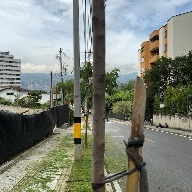

In [10]:
sample_image

In [11]:
prediction = model.inference(
    [sample_image]
)
# prediction2 = model2.inference(
#     [sample_image]
# )

[INFO ] Processed Images Done taking 0.13601160049438477 seconds. Shape:  torch.Size([1, 3, 504, 504])
[INFO ] Model Forward Pass Done. Time: 1.8592748641967773 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0015070438385009766 seconds


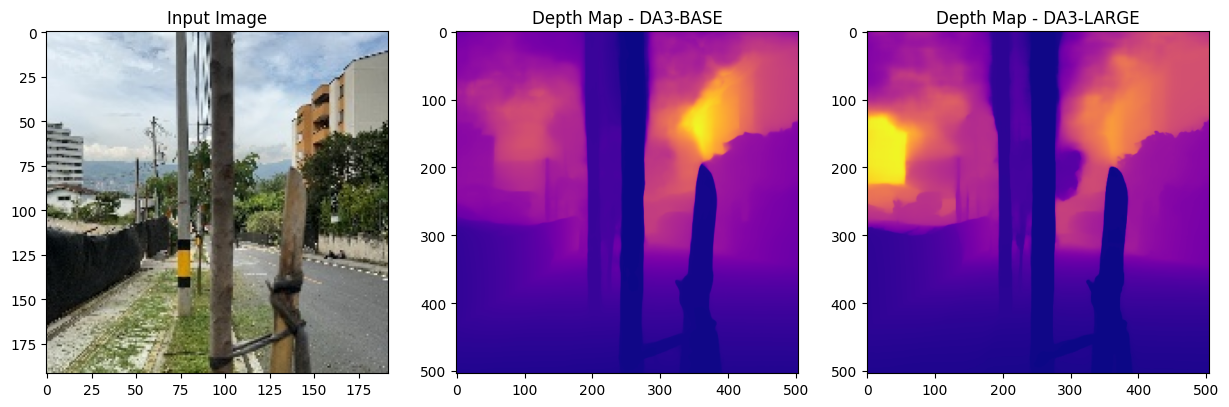

In [22]:
# show image and depth map
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(sample_image)
ax[0].set_title("Input Image")
ax[1].imshow(prediction.depth[0], cmap="plasma")
ax[1].set_title("Depth Map - DA3-BASE")
ax[2].imshow(prediction2.depth[0], cmap="plasma")
ax[2].set_title("Depth Map - DA3-LARGE")
plt.show()


In [ ]:
# batch inference and save depth maps at base_path / "depth_anything_maps/" 
# append path into dataframe new column depth_anything_maps_path
base_path = "../dataset/DepthMapDBH2023/"
model_name = "DA3-LARGE"

for split in ["train", "test"]:
    df_split = pd.read_csv(Path(base_path) / split / split / "files.csv", index_col=0)
    depth_map_paths = []
    for idx, row in tqdm(list(df_split.iterrows())):
        img_path = Path(base_path) / split / row["image_path"]
        image = Image.open(img_path).convert("RGB")
        prediction = model.inference([image])
        depth_map = prediction.depth[0]
        output_dir = Path(base_path) / split / split / "depth_anything_maps" / model_name
        output_dir.mkdir(parents=True, exist_ok=True)
        depth_map_path = output_dir / f"{split}_{idx}_depth_map.npy"
        np.save(depth_map_path, depth_map)
        depth_map_paths.append(str(depth_map_path.relative_to(base_path)))

    df_split["depth_anything_maps_path"] = depth_map_paths
    df_split.to_csv(Path(base_path) / split / split / f"files_with_depth_maps_{model_name}.csv", index=False)

  0%|          | 0/1008 [00:00<?, ?it/s]

[INFO ] Processed Images Done taking 0.015235424041748047 seconds. Shape:  torch.Size([1, 3, 504, 504])
[INFO ] Model Forward Pass Done. Time: 0.40149521827697754 seconds
[INFO ] Conversion to Prediction Done. Time: 0.001003265380859375 seconds
[INFO ] Processed Images Done taking 0.016843318939208984 seconds. Shape:  torch.Size([1, 3, 504, 504])
[INFO ] Model Forward Pass Done. Time: 0.1811199188232422 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0005054473876953125 seconds
[INFO ] Processed Images Done taking 0.014058589935302734 seconds. Shape:  torch.Size([1, 3, 504, 504])
[INFO ] Model Forward Pass Done. Time: 0.18311119079589844 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0015072822570800781 seconds
[INFO ] Processed Images Done taking 0.012072563171386719 seconds. Shape:  torch.Size([1, 3, 504, 504])
[INFO ] Model Forward Pass Done. Time: 0.18162846565246582 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0 seconds
[INFO ] Processed Images Done taking

  0%|          | 0/164 [00:00<?, ?it/s]

[INFO ] Processed Images Done taking 0.015601396560668945 seconds. Shape:  torch.Size([1, 3, 504, 504])
[INFO ] Model Forward Pass Done. Time: 0.18547892570495605 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0015091896057128906 seconds
[INFO ] Processed Images Done taking 0.012580394744873047 seconds. Shape:  torch.Size([1, 3, 504, 504])
[INFO ] Model Forward Pass Done. Time: 0.17992210388183594 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0010173320770263672 seconds
[INFO ] Processed Images Done taking 0.012026786804199219 seconds. Shape:  torch.Size([1, 3, 504, 504])
[INFO ] Model Forward Pass Done. Time: 0.18384742736816406 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0015153884887695312 seconds
[INFO ] Processed Images Done taking 0.021857738494873047 seconds. Shape:  torch.Size([1, 3, 504, 504])
[INFO ] Model Forward Pass Done. Time: 0.1934657096862793 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0020058155059814453 seconds
[INFO ] Processed

In [15]:
depth_anything_csv = pd.read_csv("../dataset/DepthMapDBH2023/train/train/files_with_depth_maps_DA3_LARGE.csv")
depth_anything_csv.head()

,image_path,depth_map_path,DBH,depth_anything_maps_path
0,train/images/0.jpg,train/depth_maps/0.png,3.023944,train\train\depth_anything_maps\DA3-LARGE\trai...
1,train/images/1.jpg,train/depth_maps/1.png,2.069014,train\train\depth_anything_maps\DA3-LARGE\trai...
2,train/images/2.jpg,train/depth_maps/2.png,2.228169,train\train\depth_anything_maps\DA3-LARGE\trai...
3,train/images/3.jpg,train/depth_maps/3.png,14.960565,train\train\depth_anything_maps\DA3-LARGE\trai...
4,train/images/4.jpg,train/depth_maps/4.png,15.915494,train\train\depth_anything_maps\DA3-LARGE\trai...


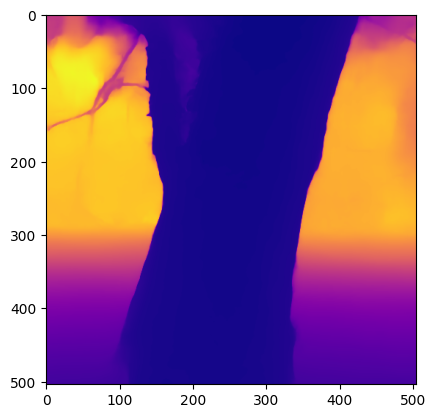

In [ ]:
n = np.load(Path(base_path) / depth_anything_csv["depth_anything_maps_path"][200])
plt.imshow(n, cmap="plasma")

In [50]:
n.shape

(504, 504)

In [2]:
import numpy as np
np.load("../dataset/DepthMapDBH2023/test/test/depth_anything_maps/DA3-LARGE/test_0_depth_map.npy").shape

(504, 504)